## Riksarkivet SBL  - Wikidata ett försök att synka och dansa med dom
version 0.47 this [notebook](https://github.com/salgo60/open-data-examples/blob/master/SBL.ipynb)

WD egenskap [Property:P3217](https://www.wikidata.org/wiki/Property:P3217) 
* SBL personartiklar som saknar [sv:Wikipedia artikel](https://w.wiki/c5f) < 150
* [SBL vs SKBL female articles](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb)  

#### Andra källor vi synkar
* [Kulturpersoner Uppsalakyrkogård](https://github.com/salgo60/open-data-examples/blob/master/Check%20WD%20kulturpersoner%20uppsalakyrkogardar.ipynb)
* [Litteraturbanken](https://github.com/salgo60/open-data-examples/blob/master/Litteraturbanken%20Author.ipynb) 
  * WD property [P5101](https://www.wikidata.org/wiki/Property_talk:P5101) [P5123](https://www.wikidata.org/wiki/Property_talk:P5123)
* [Nobelprize.org](https://github.com/salgo60/open-data-examples/blob/master/Nobel%20API.ipynb)
  * WD [property 8024](https://www.wikidata.org/wiki/Property:P8024)
* [SBL](https://github.com/salgo60/open-data-examples/blob/master/SBL.ipynb) 
  * WD [property 3217](https://www.wikidata.org/wiki/Property:P3217) 
* [SKBL](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb)
  * WD [property 4963](https://www.wikidata.org/wiki/Property:P4963)
* [Svenska Akademien](https://github.com/salgo60/open-data-examples/blob/master/Svenska%20Akademien.ipynb) 
  * WD [property 5325](https://www.wikidata.org/wiki/Property:P5325) 

### SBL
SBL har idag
* personartiklar
* släktartiklar
  * en person i en släktartikel kan ha en sida som bara pekar till släktartikeln (med text ej alltid länk)

Det saknas idag från Riksarkivet ett API så nedanstående är ett försök att webscrapa deras data och sedan försöka hitta en struktur. 

Målsättningen är att ha personerna som har en SBL personartikel representerade i Wikidata. Kul vore att även ha släktartiklarna kopplade till Wikidata... är inte säkert hur bra strukturen är för släkter/ätter/familjer i WD och sedan behövs det matchas en hel del. En person kan även omnämnas i en släktartikel och bör då i Wikidata ha "beskriven av källa" kopplad till dessa artiklar (exempel Gunnar Morssing [Q5994570#P1343](https://www.wikidata.org/wiki/Q5994570#P1343) som finns i artikel SBL ["Morssing, släkt"](https://sok.riksarkivet.se/sbl/Presentation.aspx?id=9512)) vilket är ett mycket stort jobb om Riksarkivet inte går över till att leverera [länkade data](https://sv.wikipedia.org/wiki/L%C3%A4nkade_data)... se förfrågan om bättre metadata 2019 okt 30 [T236883](https://phabricator.wikimedia.org/T236883)    

**Mina gissningar** 
1. sida med född/död är en person
2. sida med titel släkt är en släktartikel
3. sida med född/död men för kort kan vara en referens till en släktartikel
4. släkt artikel kan ha "[ätt](https://sok.riksarkivet.se/sbl/Search.aspx?t=0)" i titeln men det kan visst även person artiklar ha
5. tom sida < 12000 tecken se EmptyPageLength
6. ....

### jmf SKBL med SBL 
med ett mera komplett Wikidata kan vi nu jämföra [Svenskt Kvinnobiografiskt lexikon - SKBL](https://www.skbl.se/sv/om-skbl) med [Riksarkivet](https://sok.riksarkivet.se/sbl/OmSBL.aspx) då det gäller urval av kvinnor, antal kvinnor, hur dom levererar, API vs. inte API, skillnaden att ha enbart svenska artiklar som SBL med att även ha [engelska artiklar som SKBL](https://www.skbl.se/en/about-skbl) 

* [Notebook](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb)

# Webscrape 
1. vi gissar id min 4000 och max 40000
2. webdesignen verkar ha ändrats --> ändra size tom sida __EmptyPageLength__


In [150]:
from datetime import datetime
startdate = datetime.now()
print("Last run: ", startdate)

Last run:  2022-06-10 01:30:05.290761


In [ ]:
EmptyPageLength = 12000 # parameter to check if we webscrape an empty page right now 12000 seems ok

In [15]:
import urllib3, json
import pandas as pd   
from bs4 import BeautifulSoup
import sys
import pprint
http = urllib3.PoolManager()

from tqdm.notebook import trange  
listNewItems =[]

for SBLnr in trange(4000,40000): #gissar min 4000 max 40000
    url = "https://sok.riksarkivet.se/sbl/Presentation.aspx?id=" + str(SBLnr)
    r = http.request('GET', url) 
    if len(r.data) > EmptyPageLength: # Looks like they change the webdesign raise EmptyPageLength
        new_item = dict()
        #print(SBLnr,len(r.data))
        new_item['SBLnr'] = SBLnr
        new_item['SBLlength'] = len(r.data)
        soup = BeautifulSoup(r.data, "html.parser")  
        
        try:
            titel = soup.findAll("span", {"id": "ctl00_MainContent_lblTitle"})[0].get_text()
            new_item['titel'] = titel
            #print ("\t",titel)
        except:
            pass
        try:
            Fodd = soup.findAll("span", {"id": "ctl00_MainContent_lblFodelse"})[0].get_text()
            #print ("\t",Fodd)
            new_item['Fodd'] = Fodd
        except:
            pass
        try:
            Dod = soup.findAll("span", {"id": "ctl00_MainContent_lblDod"})[0].get_text()
            #print ("\t",Dod)
            new_item['Dod'] = Dod
        except:
            pass
        try:
            band = soup.findAll("span", {"id": "ctl00_MainContent_lblBandSida"})[0].get_text()
            #print ("\t",band)
            new_item['Band'] = band
            try:
#                year = band.get_text().split("(")[1].split(")")
                year = band.split("(")[1].split(")")[0]
                #print ("\t\tYear",year)
                new_item['Year'] = year
            except:
                pass
        except:
            pass
            
        listNewItems.append(new_item)
print (len(listNewItems) ," antal poster")
        


  0%|          | 0/36000 [00:00<?, ?it/s]

10211  antal poster


In [16]:
listNewItems[0].keys()

dict_keys(['SBLnr', 'SBLlength', 'titel', 'Fodd', 'Dod', 'Band', 'Year'])

In [17]:
import csv
if len(listNewItems) > 0:
    keys = listNewItems[0].keys()
    with open("SBL_newfile.csv", "w", newline='') as SBLfile:
        dict_writer = csv.DictWriter(SBLfile, keys)
        dict_writer.writeheader()
        dict_writer.writerows(listNewItems)

    dfSBLcsv = pd.read_csv("SBL_newfile.csv", sep=",")   
    
else:
    print ("Ingen fil skapas inga nya poster") 

In [18]:
pd.set_option("display.max.rows", None) 

In [19]:
dfSBLcsv.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10211 entries, 0 to 10210
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SBLnr      10211 non-null  int64 
 1   SBLlength  10211 non-null  int64 
 2   titel      10211 non-null  object
 3   Fodd       7117 non-null   object
 4   Dod        7602 non-null   object
 5   Band       10211 non-null  object
 6   Year       10190 non-null  object
dtypes: int64(2), object(5)
memory usage: 558.5+ KB


## Wikidata hämtar alla med P3217 satt 
dvs. även släkt kopplingar

In [20]:
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

#https://w.wiki/cvY
querySBL = """SELECT (REPLACE(STR(?item), ".*Q", "Q") AS ?wid)  ?sblid ?gender ?genderLabel WHERE {
?item wdt:P3217 ?sblid.
?item wdt:P31 wd:Q5.
optional {?item wdt:P21 ?gender}
SERVICE wikibase:label { bd:serviceParam wikibase:language "sv,en". }  
}"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDSBLtot = get_sparql_dataframe(endpoint_url, querySBL)


In [21]:
WDSBLtot.sort_index(inplace=True)  

In [22]:
WDSBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7628 entries, 0 to 7627
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   wid          7628 non-null   object
 1   sblid        7628 non-null   object
 2   gender       7628 non-null   object
 3   genderLabel  7628 non-null   object
dtypes: object(4)
memory usage: 238.5+ KB


In [23]:
%matplotlib inline    
import matplotlib.pyplot as plt   
plotSBLYearBand = dfSBLcsv["Year"].value_counts()


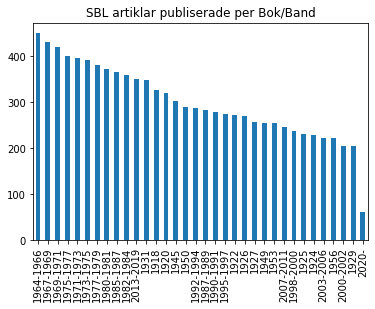

In [24]:
plotSBLYearBand.plot( kind = 'bar') 
plt.title("SBL artiklar publiserade per Bok/Band")
plt.show()

In [151]:
dfSBLcsv.sample(10)

,SBLnr,SBLlength,titel,Fodd,Dod,Band,Year
4114,12177,16654,"Johnson, släkt",NaN,NaN,"Band 20 (1973-1975), sida 350.",1973-1975
5137,13541,26659,"Halenius, släkt",NaN,NaN,"Band 17 (1967-1969), sida 770.",1967-1969
120,5622,28674,Alfred Gustaf Ahlqvist,"Född:1838-06-17 – Runstens församling, Kalmar län","Död:1881-03-26 – Växjö domkyrkoförsamling, Kro...","Band 01 (1918), sida 317.",1918
7733,17049,38665,Anders Bruhn,"Född:1778-11-25 – Stockholms stad, Stockholms län","Död:1856-02-23 – Göteborgs stad, Västra Götala...","Band 06 (1926), sida 480.",1926
6808,15854,29752,Carl Gustaf Ekman,Född:1738-12-25 – Nyköpings Alla Helgona försa...,"Död:1819-10-22 – Nikolai församling, Stockholm...","Band 13 (1950), sida 51.",1950
8474,18021,13274,"Bowallius, släkt",NaN,NaN,"Band 05 (1925), sida 611.",1925
4817,13100,16132,"Godenius, släkt",NaN,NaN,"Band 17 (1967-1969), sida 166.",1967-1969
1060,7212,27165,Petrus Philippi,NaN,"Död:1341-08-12 – Sigtuna församling, Stockholm...","Band 29 (1995-1997), sida 228.",1995-1997
5342,13824,40614,Henrik Klasson (Horn),Född:1512/13,"Död:1595-06-21 – Finland (på Kankas, Masku)","Band 19 (1971-1973), sida 353.",1971-1973
9409,20046,83221,H F (Frida) M Stéenhoff,"Född:1865-12-11 – Jakobs församling, Stockholm...","Död:1945-06-22 – Engelbrekts församling, Stock...","Band 33 (2007-2011), sida 191.",2007-2011


In [152]:
dfSBLcsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10211 entries, 0 to 10210
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SBLnr      10211 non-null  int64 
 1   SBLlength  10211 non-null  int64 
 2   titel      10211 non-null  object
 3   Fodd       7117 non-null   object
 4   Dod        7602 non-null   object
 5   Band       10211 non-null  object
 6   Year       10190 non-null  object
dtypes: int64(2), object(5)
memory usage: 558.5+ KB


In [27]:
plotSBL = dfSBLcsv.copy()
# check year eg. empty year in https://sok.riksarkivet.se/sbl/Presentation.aspx?id=34648 --> set 2021
#dfSBLcsv["Year"]
plotSBL[plotSBL["Year"].isnull()]

,SBLnr,SBLlength,titel,Fodd,Dod,Band,Year
9813,34619,11294,"Stuart, Hans (John)",NaN,NaN,"Band , sida .",NaN
9842,34648,47568,Carl Olof (Olle) Sturén,"Född:1919-02-20 – Katarina församling, Stockho...",Död:2003-05-16 – Spanien,"Band , sida .",NaN
9855,34661,11334,"Nathorst, Johan Theofil",NaN,NaN,"Band , sida .",NaN
9856,34662,11388,"Nathorst, Carl-Bertel Richard",NaN,NaN,"Band , sida .",NaN
9930,34736,11405,"Suremain, Charles Jean Baptiste de",NaN,NaN,"Band , sida .",NaN
9931,34737,11248,"Talis Qualis,",NaN,NaN,"Band , sida .",NaN
9932,34738,11199,"Vitalis,",NaN,NaN,"Band , sida .",NaN
9933,34739,11233,"Orvar Odd,",NaN,NaN,"Band , sida .",NaN
9934,34740,11204,"Arreskow,",NaN,NaN,"Band , sida .",NaN
10082,34894,11239,"Vasa, Gustav",NaN,NaN,"Band , sida .",NaN


In [28]:

plotSBL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10211 entries, 0 to 10210
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SBLnr      10211 non-null  int64 
 1   SBLlength  10211 non-null  int64 
 2   titel      10211 non-null  object
 3   Fodd       7117 non-null   object
 4   Dod        7602 non-null   object
 5   Band       10211 non-null  object
 6   Year       10190 non-null  object
dtypes: int64(2), object(5)
memory usage: 558.5+ KB


In [29]:

#plotSBL.[plotSBL["Year"].isnull()] 
#df.replace('N/A',np.NaN)
#plotSBL['Year'] = plotSBL['Year'].replace({'np.nan': "2021"})   

plotSBL["Year"].fillna("2021", inplace = True)

In [30]:
plotSBL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10211 entries, 0 to 10210
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SBLnr      10211 non-null  int64 
 1   SBLlength  10211 non-null  int64 
 2   titel      10211 non-null  object
 3   Fodd       7117 non-null   object
 4   Dod        7602 non-null   object
 5   Band       10211 non-null  object
 6   Year       10211 non-null  object
dtypes: int64(2), object(5)
memory usage: 558.5+ KB


In [31]:
import matplotlib.dates as mdates  
plotSBL["YearPublished"] = plotSBL["Year"].str[-4:] 
plotSBL.set_index('Year',inplace=True)  

In [32]:
#plotSBL["YearPublished"] = plotSBL["YearPublished"].astype("datetime64")
plotSBL["YearPublished"] = pd.to_datetime(plotSBL["YearPublished"], errors = 'coerce')

In [33]:
plotSBL.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10211 entries, 1918 to 2021
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   SBLnr          10211 non-null  int64         
 1   SBLlength      10211 non-null  int64         
 2   titel          10211 non-null  object        
 3   Fodd           7117 non-null   object        
 4   Dod            7602 non-null   object        
 5   Band           10211 non-null  object        
 6   YearPublished  10149 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 638.2+ KB


In [34]:
plotSBL.head()

,SBLnr,SBLlength,titel,Fodd,Dod,Band,YearPublished
Year,,,,,,,
1918,5490,12229,"Abelin, släkt",NaN,NaN,"Band 01 (1918), sida 1.",1918-01-01
1918,5491,33408,Gustaf R Abelin,Född:1819-05-17 – Linköpings Domkyrkoförsamlin...,"Död:1903-09-19 – Kvillinge församling, Östergö...","Band 01 (1918), sida 5.",1918-01-01
1918,5492,41845,Hjalmar A Abelin,Född:1817-05-22 – Linköpings Domkyrkoförsamlin...,"Död:1893-09-13 – Stockholms stad, Stockholms län","Band 01 (1918), sida 1.",1918-01-01
1918,5493,21919,C Rudolf Z Abelin,"Född:1864-05-30 – Malmö stad, Skåne län","Död:1961 – Västra Karups församling, Kristians...","Band 01 (1918), sida 9.",1918-01-01
1918,5494,27209,P Wilhelm Abenius,"Född:1864-05-21 – Orsa församling, Dalarnas län","Död:1956 – Ramsbergs församling, Örebro län","Band 01 (1918), sida 11.",1918-01-01


In [35]:
plotSBL["url"] = "https://sok.riksarkivet.se/sbl/Presentation.aspx?id=" + str(dfSBLcsv["SBLnr"])

In [36]:
#dfFamily = dfSBLAuthorcsv.dropna()  
dfPerson = plotSBL.dropna(subset = ['Fodd', 'Dod'])

In [37]:
dfPerson.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7110 entries, 1918 to 2020-
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   SBLnr          7110 non-null   int64         
 1   SBLlength      7110 non-null   int64         
 2   titel          7110 non-null   object        
 3   Fodd           7110 non-null   object        
 4   Dod            7110 non-null   object        
 5   Band           7110 non-null   object        
 6   YearPublished  7075 non-null   datetime64[ns]
 7   url            7110 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 499.9+ KB


### Join Wikidata
as Wikidata we guess knows what articles are about a man and a women we can try merge 

In [38]:
plotSBL['SBLnr']= plotSBL['SBLnr'].astype(str).astype(int)
plotSBL.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10211 entries, 1918 to 2021
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   SBLnr          10211 non-null  int64         
 1   SBLlength      10211 non-null  int64         
 2   titel          10211 non-null  object        
 3   Fodd           7117 non-null   object        
 4   Dod            7602 non-null   object        
 5   Band           10211 non-null  object        
 6   YearPublished  10149 non-null  datetime64[ns]
 7   url            10211 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 718.0+ KB


In [39]:
plotSBL.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10211 entries, 1918 to 2021
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   SBLnr          10211 non-null  int64         
 1   SBLlength      10211 non-null  int64         
 2   titel          10211 non-null  object        
 3   Fodd           7117 non-null   object        
 4   Dod            7602 non-null   object        
 5   Band           10211 non-null  object        
 6   YearPublished  10149 non-null  datetime64[ns]
 7   url            10211 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 718.0+ KB


In [40]:
WDSBLtot['sblid']= WDSBLtot['sblid'].astype(str).astype(int)
WDSBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7628 entries, 0 to 7627
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   wid          7628 non-null   object
 1   sblid        7628 non-null   int64 
 2   gender       7628 non-null   object
 3   genderLabel  7628 non-null   object
dtypes: int64(1), object(3)
memory usage: 238.5+ KB


In [41]:
WDSBLtot.head()

,wid,sblid,gender,genderLabel
0,Q44519,10922,http://www.wikidata.org/entity/Q6581072,kvinna
1,Q132695,9140,http://www.wikidata.org/entity/Q6581097,man
2,Q192651,13293,http://www.wikidata.org/entity/Q6581097,man
3,Q243068,11121,http://www.wikidata.org/entity/Q6581072,kvinna
4,Q275893,9141,http://www.wikidata.org/entity/Q6581072,kvinna


In [42]:
WDSBLtot["genderLabel"].value_counts()  

man         7093
kvinna       534
transman       1
Name: genderLabel, dtype: int64

In [43]:
#WDSBLtot plotSBLYearPublished  
mergeWDSBLwebscrape = pd.merge(WDSBLtot, plotSBL,how='outer',left_on='sblid', right_on='SBLnr',indicator=True)   
mergeWDSBLwebscrape.rename(columns={"_merge": "WD_Webscrape"},inplace = True)
mergeWDSBLwebscrape['WD_Webscrape'] = mergeWDSBLwebscrape['WD_Webscrape'].str.replace('left_only','WD_only').str.replace('right_only','scrape_only')
mergeWDSBLwebscrape["WD_Webscrape"].value_counts()  


both           7628
scrape_only    2584
Name: WD_Webscrape, dtype: int64

In [44]:
dfWD_SBL_article = mergeWDSBLwebscrape[mergeWDSBLwebscrape.WD_Webscrape.str.contains("both")]
#dfWDSKBLarticle.YearPublished.dt.strftime("%Y") 
#dfWDSKBLarticle.info()  
dfWD_SBL_female_article = dfWD_SBL_article[dfWD_SBL_article.genderLabel.str.contains("kvinna")]
dfWD_SBL_female_article.head()  
# Year genderLabel count

,wid,sblid,gender,genderLabel,SBLnr,SBLlength,titel,Fodd,Dod,Band,YearPublished,url,WD_Webscrape
0,Q44519,10922.0,http://www.wikidata.org/entity/Q6581072,kvinna,10922,104002,Selma O L Lagerlöf,"Född:1858-11-20 – Östra Ämterviks församling, ...","Död:1940-03-16 – Östra Ämterviks församling, V...","Band 22 (1977-1979), sida 154.",1979-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both
3,Q243068,11121.0,http://www.wikidata.org/entity/Q6581072,kvinna,11121,75717,Anne Charlotte G Leffler,"Född:1849-10-01 – Klara församling, Stockholms...",Död:1892-10-21 – Italien (i Neapel),"Band 22 (1977-1979), sida 434.",1979-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both
4,Q275893,9141.0,http://www.wikidata.org/entity/Q6581072,kvinna,9141,69066,H Maria (Moa) Martinson,"Född:1890-11-02 – Vårdnäs församling, Östergöt...",Död:1964-08-05 – Södertälje församling (Sorund...,"Band 25 (1985-1987), sida 220.",1987-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both
9,Q1679990,11113.0,http://www.wikidata.org/entity/Q6581072,kvinna,11113,43402,E Maria (Mia) L Leche Löfgren,"Född:1878-10-10 – Lunds domkyrkoförsamling, Sk...","Död:1966-04-08 – Engelbrekts församling, Stock...","Band 22 (1977-1979), sida 416.",1979-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both
25,Q4898802,5689.0,http://www.wikidata.org/entity/Q6581072,kvinna,5689,18658,H C E (Betty) Almlöf (f. Deland),"Född:1831-11-14 – Örebro Nikolai församling, Ö...","Död:1882-04-01 – Stockholms stad, Stockholms län","Band 01 (1918), sida 453.",1918-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both


In [45]:
# set date as index
#fig = plt.subplots(figsize=(15,7))

#plotSBLYearFemailPublished = dfWD_SBL_female_article["YearPublished"].dt.strftime("%Y").value_counts().sort_index().plot(kind='bar', color=['red'])

#plt.title("SBL articles published per Year about women 1918-2019")
#plt.savefig('SBL_published_articles_women_1918-2018.png')  
#plt.show()  
#plotSBLYearPublished.info 


In [46]:
#dfWD_SBL_female_article["YearPublished"].dt.strftime("%Y").value_counts().sort_index(ascending=False)

In [47]:
dfWD_SBL_female_article.head()

,wid,sblid,gender,genderLabel,SBLnr,SBLlength,titel,Fodd,Dod,Band,YearPublished,url,WD_Webscrape
0,Q44519,10922.0,http://www.wikidata.org/entity/Q6581072,kvinna,10922,104002,Selma O L Lagerlöf,"Född:1858-11-20 – Östra Ämterviks församling, ...","Död:1940-03-16 – Östra Ämterviks församling, V...","Band 22 (1977-1979), sida 154.",1979-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both
3,Q243068,11121.0,http://www.wikidata.org/entity/Q6581072,kvinna,11121,75717,Anne Charlotte G Leffler,"Född:1849-10-01 – Klara församling, Stockholms...",Död:1892-10-21 – Italien (i Neapel),"Band 22 (1977-1979), sida 434.",1979-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both
4,Q275893,9141.0,http://www.wikidata.org/entity/Q6581072,kvinna,9141,69066,H Maria (Moa) Martinson,"Född:1890-11-02 – Vårdnäs församling, Östergöt...",Död:1964-08-05 – Södertälje församling (Sorund...,"Band 25 (1985-1987), sida 220.",1987-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both
9,Q1679990,11113.0,http://www.wikidata.org/entity/Q6581072,kvinna,11113,43402,E Maria (Mia) L Leche Löfgren,"Född:1878-10-10 – Lunds domkyrkoförsamling, Sk...","Död:1966-04-08 – Engelbrekts församling, Stock...","Band 22 (1977-1979), sida 416.",1979-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both
25,Q4898802,5689.0,http://www.wikidata.org/entity/Q6581072,kvinna,5689,18658,H C E (Betty) Almlöf (f. Deland),"Född:1831-11-14 – Örebro Nikolai församling, Ö...","Död:1882-04-01 – Stockholms stad, Stockholms län","Band 01 (1918), sida 453.",1918-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both


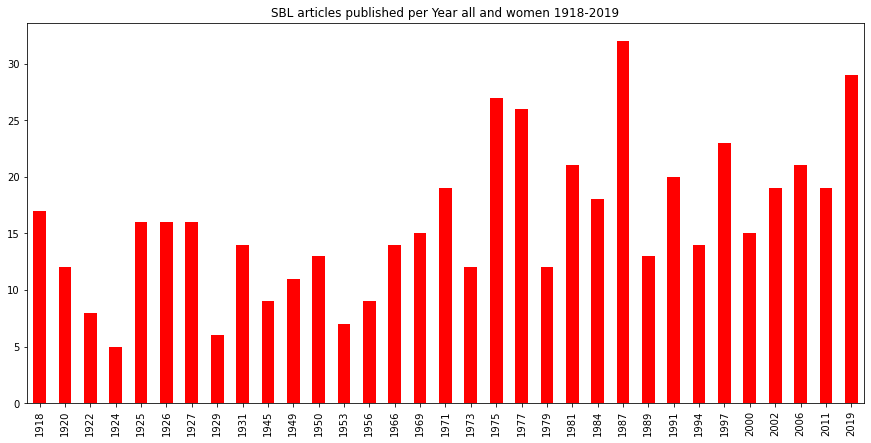

In [48]:
fig = plt.subplots(figsize=(15,7))

plotSBLYearFemailPublished = dfWD_SBL_female_article["YearPublished"].dt.strftime("%Y").value_counts().sort_index().plot(kind='bar', color=['red'])
#plotSBLYearPublished = plotSBL["YearPublished"].dt.strftime("%Y").value_counts().sort_index()
#plotSBLYearPublished.plot( kind = 'bar', color=['g']) 
plt.title("SBL articles published per Year all and women 1918-2019")
plt.savefig('SBL_published_articles_all_women_1918-2018.png')  
plt.show()  

In [49]:
speed = [0.1, 17.5, 40, 48, 52, 69, 88]
lifespan = [2, 8, 70, 1.5, 25, 12, 28]
index = ['snail', 'pig', 'elephant',
          'rabbit', 'giraffe', 'coyote', 'horse']
df = pd.DataFrame({'speed': speed,
                    'lifespan': lifespan}, index=index)
#ax = df.plot.bar(rot=0)


#plotSBLYearPublished_FM = dfWD_SBL_article.groupby(["YearPublished"])
#plotSBLYearPublished_FM = dfWD_SBL_article.groupby(["YearPublished"])["genderLabel"].transform("count")
#df['Counts'] = df.groupby(['Color'])['Value'].transform('count')
#plotSBLYearPublished_FM.head()  
dfWD_SBL_article.info()
dfWD_SBL_article.head()

# Group by YearPublished genderLabel

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7628 entries, 0 to 7627
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wid            7628 non-null   object        
 1   sblid          7628 non-null   float64       
 2   gender         7628 non-null   object        
 3   genderLabel    7628 non-null   object        
 4   SBLnr          7628 non-null   int64         
 5   SBLlength      7628 non-null   int64         
 6   titel          7628 non-null   object        
 7   Fodd           7109 non-null   object        
 8   Dod            7587 non-null   object        
 9   Band           7628 non-null   object        
 10  YearPublished  7596 non-null   datetime64[ns]
 11  url            7628 non-null   object        
 12  WD_Webscrape   7628 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(9)
memory usage: 834.3+ KB


,wid,sblid,gender,genderLabel,SBLnr,SBLlength,titel,Fodd,Dod,Band,YearPublished,url,WD_Webscrape
0,Q44519,10922.0,http://www.wikidata.org/entity/Q6581072,kvinna,10922,104002,Selma O L Lagerlöf,"Född:1858-11-20 – Östra Ämterviks församling, ...","Död:1940-03-16 – Östra Ämterviks församling, V...","Band 22 (1977-1979), sida 154.",1979-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both
1,Q132695,9140.0,http://www.wikidata.org/entity/Q6581097,man,9140,207392,Harry E Martinson,"Född:1904-05-06 – Jämshögs församling, Bleking...","Död:1978-02-11 – Sollentuna församling, Stockh...","Band 25 (1985-1987), sida 204.",1987-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both
2,Q192651,13293.0,http://www.wikidata.org/entity/Q6581097,man,13293,41879,Allvar Gullstrand,"Född:1862-06-05 – Landskrona församling, Skåne...","Död:1930-07-28 – Oscars församling, Stockholms...","Band 17 (1967-1969), sida 404.",1969-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both
3,Q243068,11121.0,http://www.wikidata.org/entity/Q6581072,kvinna,11121,75717,Anne Charlotte G Leffler,"Född:1849-10-01 – Klara församling, Stockholms...",Död:1892-10-21 – Italien (i Neapel),"Band 22 (1977-1979), sida 434.",1979-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both
4,Q275893,9141.0,http://www.wikidata.org/entity/Q6581072,kvinna,9141,69066,H Maria (Moa) Martinson,"Född:1890-11-02 – Vårdnäs församling, Östergöt...",Död:1964-08-05 – Södertälje församling (Sorund...,"Band 25 (1985-1987), sida 220.",1987-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both


### Släktartiklar  
Nedan lite gissning att en släktartikel har ordet släkt i titeln. 

* se också [webscarping Adelsvapen](https://gist.github.com/salgo60/31e0c4bf6f075c373fb5bbfb6cc807c6)
* csv lista skapad nedan på [GIST](https://gist.github.com/salgo60/31e0c4bf6f075c373fb5bbfb6cc807c6#gistcomment-3457126) 

In [50]:
dfFamily = plotSBL[plotSBL.isnull().any(1)]

In [51]:
dfFamily.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3136 entries, 1918 to 2021
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   SBLnr          3136 non-null   int64         
 1   SBLlength      3136 non-null   int64         
 2   titel          3136 non-null   object        
 3   Fodd           42 non-null     object        
 4   Dod            527 non-null    object        
 5   Band           3136 non-null   object        
 6   YearPublished  3074 non-null   datetime64[ns]
 7   url            3136 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 220.5+ KB


In [52]:
#dfFamily

In [53]:
dfFamilySlakt = dfFamily[dfFamily.titel.str.contains("släkt")]
#dfFamilySlakt

In [54]:
dictFamily = dfFamilySlakt.to_dict()

In [55]:
dfFamily.titel.str.contains("släkt").sum()

1725

In [56]:
dfFamily.titel.str.contains("ätten").sum()

38

In [57]:
dfFamily.titel.str.contains("Släkt").sum()

1

In [58]:
dfFamily.Dod.str.contains("senas").sum()

23

In [59]:
#dfFamily[dfFamily.Dod.str.contains("senas", na=False)]

In [156]:
dfFamily[dfFamily.Fodd.str.contains("", na=False)].sample(10)

,SBLnr,SBLlength,titel,Fodd,Dod,Band,YearPublished,url
Year,,,,,,,,
2020-,34990,33489,Kurt Karl Albert Swolin,Född:1923-05-23 – Tyskland (Wuppertal),"Död:1998-04-14 – (Näset, V Göt)","Band 35 (2020-), sida 37.",NaT,https://sok.riksarkivet.se/sbl/Presentation.as...
1931,15785,56493,Robert Dahlander,"Född:1870-06-09 – Göteborgs stad, Västra Götal...",NaN,"Band 09 (1931), sida 596.",1931-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...
2020-,35003,11945,Jacob Svinhufvud,Född:1677,Död:1738,"Band 35 (2020-), sida 23.",NaT,https://sok.riksarkivet.se/sbl/Presentation.as...
2020-,35033,42058,Lajos Szécsi,Född:1930-02-27 – Ungern (Budapest),"Död:2004-10-15 – Skarpnäcks församling, Stockh...","Band 35 (2020-), sida 149.",NaT,https://sok.riksarkivet.se/sbl/Presentation.as...
2020-,35020,44493,Arvid Swärd,"Född:1886-08-11 – Sörby församling (L-län), Kr...","Död:1961-10-16 – Hedvig Eleonora församling, S...","Band 35 (2020-), sida 43.",NaT,https://sok.riksarkivet.se/sbl/Presentation.as...
1918,5671,18231,A Adele L Almati-Rundberg,"Född:1861-02-23 – USA, Amerikas Förenta Stater...",NaN,"Band 01 (1918), sida 417.",1918-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...
2020-,35001,11954,Christer Jönsson,Född:1607,Död:1660,"Band 35 (2020-), sida 23.",NaT,https://sok.riksarkivet.se/sbl/Presentation.as...
1918,5735,24834,Johan Mathias Ambrosius,Född:1843-02-08,NaN,"Band 01 (1918), sida 576.",1918-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...
2020-,35041,66773,Carl Wilhelm von Sydow,"Född:1878-12-21 – Ryssby församling (G-län), K...","Död:1952-03-04 – Lunds domkyrkoförsamling, Skå...","Band 35 (2020-), sida 77.",NaT,https://sok.riksarkivet.se/sbl/Presentation.as...


In [94]:
#Check diff WDSBLtot and plotSBL 
WDSBLtot.duplicated(subset=['wid']).sum()

0

In [95]:
plotSBL.duplicated(subset=['SBLnr']).sum()

0

In [97]:
#WDSBLtot.duplicated(subset=['sblid']).sum()

In [98]:
WDSBLtot = WDSBLtot.rename(columns={'sblid':'SBLnr'})
WDSBLtot['SBLnr']= WDSBLtot['SBLnr'].astype(str).astype(int)
WDSBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7628 entries, 0 to 7627
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   wid          7628 non-null   object
 1   SBLnr        7628 non-null   int64 
 2   gender       7628 non-null   object
 3   genderLabel  7628 non-null   object
dtypes: int64(1), object(3)
memory usage: 238.5+ KB


In [99]:
dfmerge = pd.merge(WDSBLtot, plotSBL,how='outer', on='SBLnr',indicator=True)

In [100]:
dfmerge["_merge"].value_counts()

both          7628
right_only    2584
left_only        0
Name: _merge, dtype: int64

In [101]:
#dfmerge

In [102]:
dfmerge['_merge'] = dfmerge['_merge'].str.replace('left_only','WD_only').str.replace('right_only','SBL_only')


In [103]:
WDSBLonly = dfmerge[dfmerge["_merge"] == "SBL_only"].copy()   
dfmerge["_merge"].value_counts()

both        7628
SBL_only    2584
Name: _merge, dtype: int64

In [104]:
WD_only = dfmerge[dfmerge["_merge"] == "WD_only"].copy()   
WD_only

,wid,SBLnr,gender,genderLabel,SBLlength,titel,Fodd,Dod,Band,YearPublished,url,_merge


In [105]:
WDSBLonly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2584 entries, 7628 to 10211
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wid            0 non-null      object        
 1   SBLnr          2584 non-null   int64         
 2   gender         0 non-null      object        
 3   genderLabel    0 non-null      object        
 4   SBLlength      2584 non-null   int64         
 5   titel          2584 non-null   object        
 6   Fodd           8 non-null      object        
 7   Dod            16 non-null     object        
 8   Band           2584 non-null   object        
 9   YearPublished  2554 non-null   datetime64[ns]
 10  url            2584 non-null   object        
 11  _merge         2584 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 262.4+ KB


In [106]:
WDSBLonly.titel.str.contains("släkt").sum() 


1688

In [153]:
WDSBLonly[WDSBLonly.titel.str.contains("ätt")].head(10)

,wid,SBLnr,gender,genderLabel,SBLlength,titel,Fodd,Dod,Band,YearPublished,url,_merge
7808,NaN,7249,NaN,NaN,23681,"Pfalziska ätten,",NaN,NaN,"Band 29 (1995-1997), sida 283.",1997-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
7980,NaN,9007,NaN,NaN,41975,"Malsta-ätten,",NaN,NaN,"Band 25 (1985-1987), sida 40.",1987-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
7981,NaN,9008,NaN,NaN,11219,"(Malsta-ätten), Kettil Johansson",NaN,NaN,"Band 25 (1985-1987), sida 41.",1987-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
7982,NaN,9009,NaN,NaN,11209,"(Malsta-ätten), Thomas Jonsson",NaN,NaN,"Band 25 (1985-1987), sida 40.",1987-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8274,NaN,11237,NaN,NaN,39858,"Lepasätten, släkt",NaN,NaN,"Band 22 (1977-1979), sida 579.",1979-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8275,NaN,11238,NaN,NaN,11213,"(Lepasätten), Björn Clausson",NaN,NaN,"Band 22 (1977-1979), sida 579.",1979-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8276,NaN,11239,NaN,NaN,11213,"(Lepasätten), Hans Björnsson",NaN,NaN,"Band 22 (1977-1979), sida 580.",1979-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8293,NaN,11376,NaN,NaN,34717,"Likvidssönernas ätt,",NaN,NaN,"Band 22 (1977-1979), sida 767.",1979-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8294,NaN,11377,NaN,NaN,11317,"(Likvidssönernas ätt), Anund Hemmingsson",NaN,NaN,"Band 22 (1977-1979), sida 768.",1979-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8295,NaN,11378,NaN,NaN,11307,"(Likvidssönernas ätt), Hemming Larsson",NaN,NaN,"Band 22 (1977-1979), sida 768.",1979-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only


In [108]:
#Inte släkt 
WDmissingPerson = WDSBLonly[~WDSBLonly.titel.str.contains("släkt")]

In [109]:
WDmissingPerson.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 896 entries, 7630 to 10211
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wid            0 non-null      object        
 1   SBLnr          896 non-null    int64         
 2   gender         0 non-null      object        
 3   genderLabel    0 non-null      object        
 4   SBLlength      896 non-null    int64         
 5   titel          896 non-null    object        
 6   Fodd           8 non-null      object        
 7   Dod            16 non-null     object        
 8   Band           896 non-null    object        
 9   YearPublished  868 non-null    datetime64[ns]
 10  url            896 non-null    object        
 11  _merge         896 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 91.0+ KB


In [111]:
WDmissingPerson["YearPublished"].value_counts()

2019-01-01    140
2011-01-01     66
1953-01-01     54
1987-01-01     44
2006-01-01     36
1931-01-01     34
1950-01-01     33
1994-01-01     31
1979-01-01     31
1984-01-01     28
1981-01-01     27
2000-01-01     26
1975-01-01     24
1966-01-01     24
1971-01-01     21
1969-01-01     21
1945-01-01     21
1989-01-01     21
2002-01-01     21
1956-01-01     21
2021-01-01     20
1929-01-01     20
1949-01-01     16
1973-01-01     12
1991-01-01     11
1926-01-01     10
1977-01-01     10
1920-01-01     10
1997-01-01      8
1925-01-01      7
1918-01-01      7
1927-01-01      5
1924-01-01      4
1922-01-01      4
Name: YearPublished, dtype: int64

In [112]:
print("Min, Max SBLlength: ", WDmissingPerson.SBLlength.min(), WDmissingPerson.SBLlength.max())

Min, Max SBLlength:  11194 74771


In [113]:
# sorterar artiklarna efter sidstorlek för att kanske hitta någon vi missat  
# wid är Wikidata objekt , NaN är att det saknas  
# SBLnr är id i SBL
# SBLlength är sidans storlek hos SBL 
# Fodd, Dod... är det jag hittade i WEBsidan, NaN innebär saknas

#WDmissingPerson.sort_values(by='SBLlength', ascending=False, na_position='first')

In [114]:
WDmissingPerson.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 896 entries, 7630 to 10211
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wid            0 non-null      object        
 1   SBLnr          896 non-null    int64         
 2   gender         0 non-null      object        
 3   genderLabel    0 non-null      object        
 4   SBLlength      896 non-null    int64         
 5   titel          896 non-null    object        
 6   Fodd           8 non-null      object        
 7   Dod            16 non-null     object        
 8   Band           896 non-null    object        
 9   YearPublished  868 non-null    datetime64[ns]
 10  url            896 non-null    object        
 11  _merge         896 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 91.0+ KB


In [115]:
WDmissingPerson["YearPublished"].value_counts()

2019-01-01    140
2011-01-01     66
1953-01-01     54
1987-01-01     44
2006-01-01     36
1931-01-01     34
1950-01-01     33
1994-01-01     31
1979-01-01     31
1984-01-01     28
1981-01-01     27
2000-01-01     26
1975-01-01     24
1966-01-01     24
1971-01-01     21
1969-01-01     21
1945-01-01     21
1989-01-01     21
2002-01-01     21
1956-01-01     21
2021-01-01     20
1929-01-01     20
1949-01-01     16
1973-01-01     12
1991-01-01     11
1926-01-01     10
1977-01-01     10
1920-01-01     10
1997-01-01      8
1925-01-01      7
1918-01-01      7
1927-01-01      5
1924-01-01      4
1922-01-01      4
Name: YearPublished, dtype: int64

In [116]:
print("End run: ", datetime.now())

End run:  2022-06-09 22:43:45.802968


In [117]:
#Släkt 
#WDSlakt = WDSBLonly[~WDSBLonly.titel.str.contains("släkt")].copy

In [118]:
WDSlakt = WDSBLonly[WDSBLonly.titel.str.contains("släkt")]

In [119]:
WDSlakt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1688 entries, 7628 to 10202
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wid            0 non-null      object        
 1   SBLnr          1688 non-null   int64         
 2   gender         0 non-null      object        
 3   genderLabel    0 non-null      object        
 4   SBLlength      1688 non-null   int64         
 5   titel          1688 non-null   object        
 6   Fodd           0 non-null      object        
 7   Dod            0 non-null      object        
 8   Band           1688 non-null   object        
 9   YearPublished  1686 non-null   datetime64[ns]
 10  url            1688 non-null   object        
 11  _merge         1688 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 171.4+ KB


In [120]:
#Need a workaround as pandas to_csv dont work ?!?!?
#for  index,row in WDSlakt.iterrows():
#    print(row["SBLnr"],row["titel"],row["Year"],row["url"])    
#    print(row["SBLnr"],"|",row["titel"],"|",row["Year"])  

List produced also on [GIST](https://gist.github.com/salgo60/31e0c4bf6f075c373fb5bbfb6cc807c6#gistcomment-3457126) 

### Estimate published articles male/female /family


In [121]:
dfmerge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10212 entries, 0 to 10211
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wid            7628 non-null   object        
 1   SBLnr          10212 non-null  int64         
 2   gender         7628 non-null   object        
 3   genderLabel    7628 non-null   object        
 4   SBLlength      10212 non-null  int64         
 5   titel          10212 non-null  object        
 6   Fodd           7117 non-null   object        
 7   Dod            7603 non-null   object        
 8   Band           10212 non-null  object        
 9   YearPublished  10150 non-null  datetime64[ns]
 10  url            10212 non-null  object        
 11  _merge         10212 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 1.0+ MB


In [122]:
personSBL = dfmerge[~dfmerge['wid'].isnull()] 

In [123]:
personSBL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7628 entries, 0 to 7627
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wid            7628 non-null   object        
 1   SBLnr          7628 non-null   int64         
 2   gender         7628 non-null   object        
 3   genderLabel    7628 non-null   object        
 4   SBLlength      7628 non-null   int64         
 5   titel          7628 non-null   object        
 6   Fodd           7109 non-null   object        
 7   Dod            7587 non-null   object        
 8   Band           7628 non-null   object        
 9   YearPublished  7596 non-null   datetime64[ns]
 10  url            7628 non-null   object        
 11  _merge         7628 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 774.7+ KB


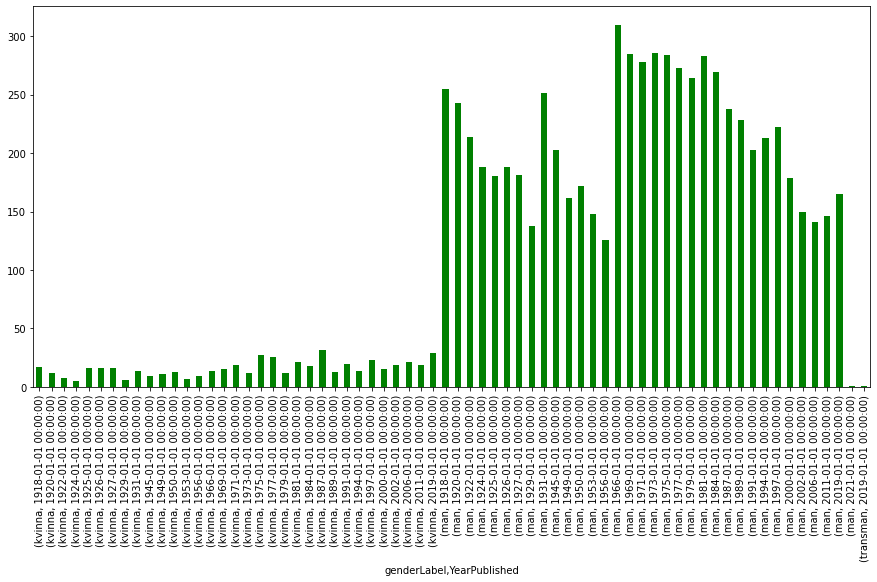

In [137]:
fig = plt.subplots(figsize=(15,7))
plotSBLGender = personSBL.groupby(["genderLabel", "YearPublished"]).size()
#plotSBLGender  
plotSBLGender.plot( kind = 'bar', color=['g'],) 
plt.show()

In [149]:
#plotSBLGender = personSBL.groupby(["genderLabel", "YearPublished"]).size()
personSBL.info()
#plotSBLGender.pivot("genderLabel", "YearPublished")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7628 entries, 0 to 7627
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wid            7628 non-null   object        
 1   SBLnr          7628 non-null   int64         
 2   gender         7628 non-null   object        
 3   genderLabel    7628 non-null   object        
 4   SBLlength      7628 non-null   int64         
 5   titel          7628 non-null   object        
 6   Fodd           7109 non-null   object        
 7   Dod            7587 non-null   object        
 8   Band           7628 non-null   object        
 9   YearPublished  7596 non-null   datetime64[ns]
 10  url            7628 non-null   object        
 11  _merge         7628 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 774.7+ KB


In [136]:
plotSBLGender.unstack()

YearPublished,1918-01-01,1920-01-01,1922-01-01,1924-01-01,1925-01-01,1926-01-01,1927-01-01,1929-01-01,1931-01-01,1945-01-01,...,1989-01-01,1991-01-01,1994-01-01,1997-01-01,2000-01-01,2002-01-01,2006-01-01,2011-01-01,2019-01-01,2021-01-01
genderLabel,,,,,,,,,,,,,,,,,,,,,
kvinna,17.0,12.0,8.0,5.0,16.0,16.0,16.0,6.0,14.0,9.0,...,13.0,20.0,14.0,23.0,15.0,19.0,21.0,19.0,29.0,NaN
man,255.0,243.0,214.0,188.0,180.0,188.0,181.0,138.0,251.0,203.0,...,228.0,203.0,213.0,222.0,179.0,150.0,141.0,146.0,165.0,1.0
transman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [129]:
end = datetime.now()
print("Ended: ", end) 
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - startdate))

Ended:  2022-06-09 22:44:56.834373
Time elapsed (hh:mm:ss.ms) 1:19:32.664877
